In [1]:
from dataclasses import dataclass
from datetime import datetime

import sklearn.metrics as metrics
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np 
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from tqdm.auto import tqdm
from torchfuzzy import FuzzyLayer, DefuzzyLinearLayer, FuzzyBellLayer
import os

os.environ['CUDA_LAUNCH_BLOCKING']="1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

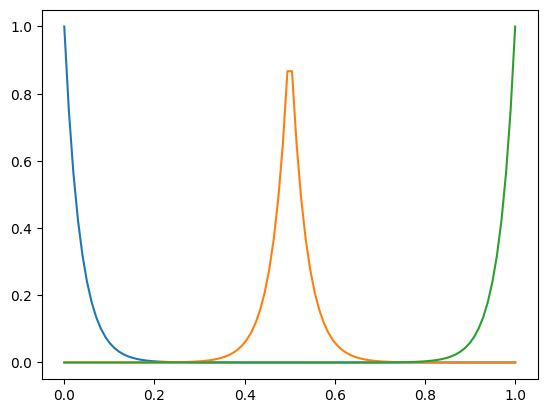

tensor([[20.+0.j, 20.+0.j],
        [20.+0.j, 20.+0.j],
        [20.+0.j, 20.+0.j]], device='cuda:0', grad_fn=<LinalgEigBackward0>)

In [9]:
initial_centroids = []
initial_scales = []
sd = 3
exp_k = 20
maxx = 1
for x in np.linspace(0.0, maxx, num = sd):
    initial_centroids.append([exp_k*(x), exp_k*(x)]) #
    initial_scales.append([exp_k, exp_k])  
    
        
fzl = FuzzyLayer.from_centers_and_scales(initial_centroids, initial_scales, trainable=False).to(device)

fzx = []
fzy = []
for x in np.linspace(0, maxx, num=100):
    inp = torch.FloatTensor([x, x]).reshape((-1, 2)).to(device)
    fz = fzl(inp)
    fzx.append(x)
    fzy.append(fz[0].detach().cpu().numpy())#

plt.plot(fzx, fzy)
plt.show()
fzl.get_transformation_matrix_eigenvals()

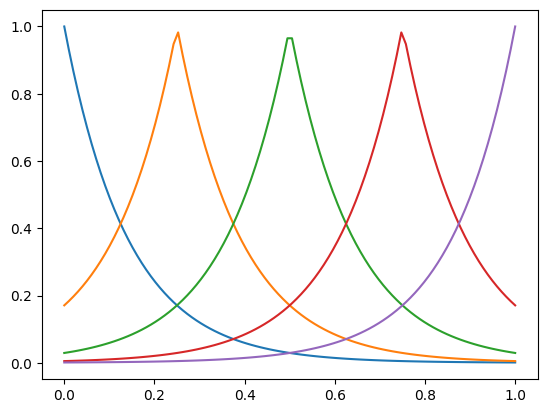

In [5]:
initial_centroids = []
initial_scales = []
initial_pow = []
sd = 5
exp_k = 5
maxx = 1
for x in np.linspace(0.0, maxx, num = sd):
    initial_centroids.append([exp_k*(x), exp_k*(x)]) #
    initial_scales.append([exp_k, exp_k])  
    initial_pow.append([2])
        
fzl = FuzzyLayer.from_centers_and_scales(initial_centroids, initial_scales, trainable=False).to(device)

fzx = []
fzy = []
for x in np.linspace(0, maxx, num=100):
    inp = torch.FloatTensor([x, x]).reshape((-1, 2)).to(device)
    fz = fzl(inp)
    fzx.append(x)
    fzy.append(fz[0].detach().cpu().numpy())#

plt.plot(fzx, fzy)
plt.show()

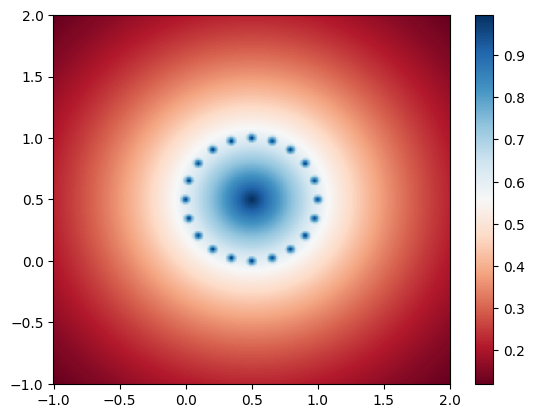

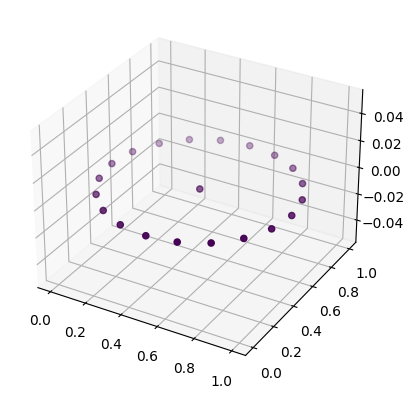

In [15]:
fuzzy_rules_count = 21
latent_dim = 3
rscale = 10
initial_centroids = rscale * np.zeros((fuzzy_rules_count, latent_dim))
initial_scales = rscale * np.ones((fuzzy_rules_count, latent_dim))
radius = 0.5
center = 0.5
theta = np.linspace(0, 2*np.pi, fuzzy_rules_count)[:-1]
x = radius * np.cos(theta) + center
y = radius * np.sin(theta) + center
for i in range(fuzzy_rules_count-1):
    initial_centroids[i][0] = rscale * x[i]
    initial_centroids[i][1] = rscale * y[i]

initial_centroids[fuzzy_rules_count-1][0] = center
initial_centroids[fuzzy_rules_count-1][1] = center
initial_scales[fuzzy_rules_count-1][0] = 1
initial_scales[fuzzy_rules_count-1][1] = 1

fzl = FuzzyLayer.from_centers_and_scales(initial_centroids, initial_scales, trainable=False).to(device)

xmin, xmax = -1, 2
ymin, ymax = -1, 2
szw = 500
mesh = []
for x in np.linspace(xmin, xmax, num=szw):
    for y in np.linspace(ymin, ymax, num=szw):
        mesh.append([x, y, 0.0])

x = np.array([a[0] for a in mesh]).reshape((szw,szw))
y = np.array([a[1] for a in mesh]).reshape((szw,szw))
plt_z = np.array([a[2] for a in mesh]).reshape((szw,szw))
inp = torch.FloatTensor(mesh).reshape((-1, 3)).to(device)
fz = fzl(inp)

z = fz.max(-1).values.squeeze().detach().cpu().numpy().reshape((szw,szw))

z_min, z_max = z.min(), z.max()
c = plt.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
plt.colorbar(c)
plt.show()

centroids = fzl.get_centroids().detach().cpu().numpy()
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter([a[0] for a in centroids],[a[1] for a in centroids], [a[2] for a in centroids], c= [a[2] for a in centroids], cmap='viridis')
plt.show()

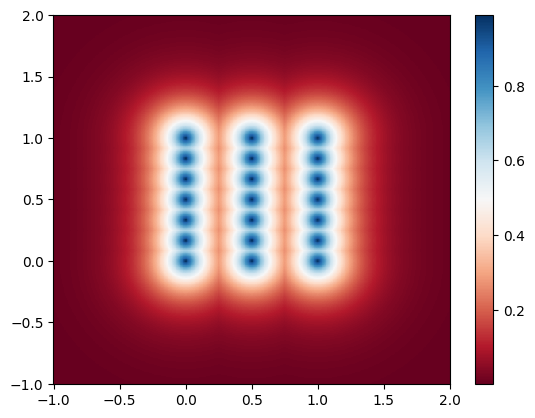

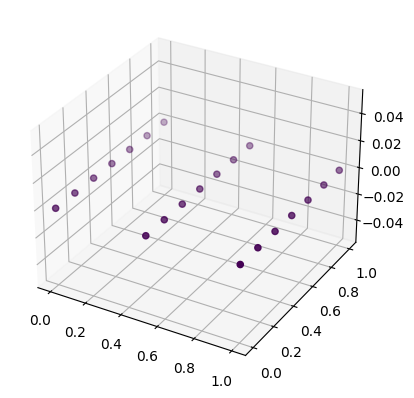

In [19]:
fuzzy_rules_count = 21
latent_dim = 3

rscale = 5
initial_centroids = rscale * np.zeros((fuzzy_rules_count, latent_dim))
initial_scales = rscale * np.ones((fuzzy_rules_count, latent_dim))

linex = 0
linez = 0
i = 0
for x in np.linspace(0.0, 1.0, num = 3):
    for y in np.linspace(0.0, 1.0, num = fuzzy_rules_count // 3):
        initial_centroids[i][0] = rscale*(x)
        initial_centroids[i][1] = rscale*(y)
        i = i + 1
        
fzl = FuzzyLayer.from_centers_and_scales(initial_centroids, initial_scales, trainable=False).to(device)

xmin, xmax = -1, 2
ymin, ymax = -1, 2
szw = 500
mesh = []
for x in np.linspace(xmin, xmax, num=szw):
    for y in np.linspace(ymin, ymax, num=szw):
        mesh.append([x, y, 0.0])

x = np.array([a[0] for a in mesh]).reshape((szw,szw))
y = np.array([a[1] for a in mesh]).reshape((szw,szw))
plt_z = np.array([a[2] for a in mesh]).reshape((szw,szw))
inp = torch.FloatTensor(mesh).reshape((-1, 3)).to(device)
fz = fzl(inp)

z = fz.max(-1).values.squeeze().detach().cpu().numpy().reshape((szw,szw))

z_min, z_max = z.min(), z.max()
c = plt.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
plt.colorbar(c)
plt.show()

centroids = fzl.get_centroids().detach().cpu().numpy()
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter([a[0] for a in centroids],[a[1] for a in centroids], [a[2] for a in centroids], c= [a[2] for a in centroids], cmap='viridis')
plt.show()

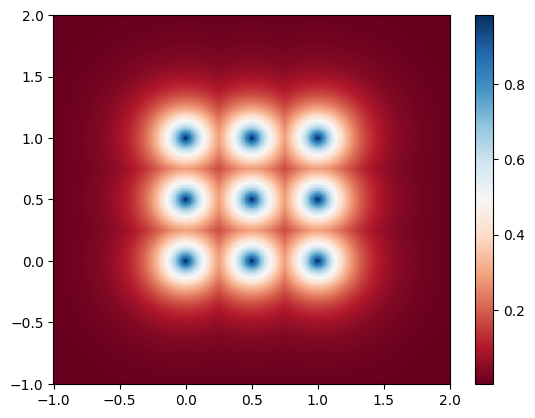

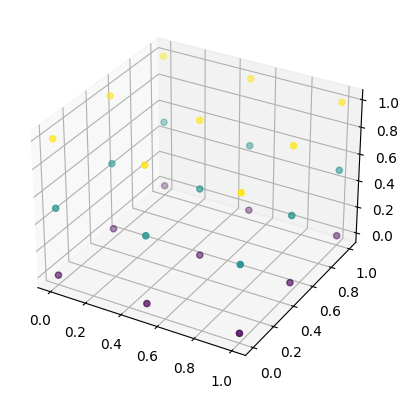

In [9]:
initial_centroids = []
initial_scales = []
sd = 3
exp_k = 5
linex = 0
linez = 0
for x in np.linspace(0.0, 1.0, num = sd):
    linex += 1
    for y in np.linspace(0.0, 1.0, num = sd):
        linez+=1
        for z in np.linspace(0.0, 1.0, num = sd):
            initial_centroids.append([exp_k*(x), 
                                      exp_k*(y ), #+ (0.5/sd if linex%2 == 0 else 0)
                                      exp_k*(z)#+(0.5/sd if linez%2 == 0 else 0)
                                      ]) #
            initial_scales.append([exp_k, exp_k, exp_k])  
        
fzl = FuzzyLayer.from_centers_and_scales(initial_centroids, initial_scales, trainable=False).to(device)

xmin, xmax = -1, 2
ymin, ymax = -1, 2
szw = 500
mesh = []
for x in np.linspace(xmin, xmax, num=szw):
    for y in np.linspace(ymin, ymax, num=szw):
        mesh.append([x, y, 0.0])

x = np.array([a[0] for a in mesh]).reshape((szw,szw))
y = np.array([a[1] for a in mesh]).reshape((szw,szw))
plt_z = np.array([a[2] for a in mesh]).reshape((szw,szw))
inp = torch.FloatTensor(mesh).reshape((-1, 3)).to(device)
fz = fzl(inp)

z = fz.max(-1).values.squeeze().detach().cpu().numpy().reshape((szw,szw))

z_min, z_max = z.min(), z.max()
c = plt.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
plt.colorbar(c)
plt.show()

centroids = fzl.get_centroids().detach().cpu().numpy()
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter([a[0] for a in centroids],[a[1] for a in centroids], [a[2] for a in centroids], c= [a[2] for a in centroids], cmap='viridis')
plt.show()

In [10]:
fzl.get_centroids()

tensor([[0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.2500],
        [0.0000, 0.0000, 0.5000],
        [0.0000, 0.0000, 0.7500],
        [0.0000, 0.0000, 1.0000],
        [0.0000, 0.2500, 0.1000],
        [0.0000, 0.2500, 0.3500],
        [0.0000, 0.2500, 0.6000],
        [0.0000, 0.2500, 0.8500],
        [0.0000, 0.2500, 1.1000],
        [0.0000, 0.5000, 0.0000],
        [0.0000, 0.5000, 0.2500],
        [0.0000, 0.5000, 0.5000],
        [0.0000, 0.5000, 0.7500],
        [0.0000, 0.5000, 1.0000],
        [0.0000, 0.7500, 0.1000],
        [0.0000, 0.7500, 0.3500],
        [0.0000, 0.7500, 0.6000],
        [0.0000, 0.7500, 0.8500],
        [0.0000, 0.7500, 1.1000],
        [0.0000, 1.0000, 0.0000],
        [0.0000, 1.0000, 0.2500],
        [0.0000, 1.0000, 0.5000],
        [0.0000, 1.0000, 0.7500],
        [0.0000, 1.0000, 1.0000],
        [0.2500, 0.1000, 0.1000],
        [0.2500, 0.1000, 0.3500],
        [0.2500, 0.1000, 0.6000],
        [0.2500, 0.1000, 0.8500],
        [0.250